# SETUP

In [22]:
#link to the google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
 #Check the package pyreadr.
 !pip install pyreadr

     |████████████████████████████████| 409 kB 5.3 MB/s 


In [72]:
import pandas as pd 
import pyreadr as py 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib as plt
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None

In [4]:
#TPU

import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU address is grpc://10.126.157.170:8470
Running on TPU  grpc://10.126.157.170:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.126.157.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.157.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER

In [5]:
BASE_SEQ_LEN = 500
NUM_VAR = 52
INPUT_SEQ_LEN = 32 
OUTPUT_SEQ_LEN = 1 
BATCH_SIZE = 128

# READ DATA

In [6]:
a1 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Training.RData")
fault_free_training = a1['fault_free_training']
a1 = None 
a2 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Training.RData")
faulty_training = a2['faulty_training']
a2 = None
a3 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Testing.RData")
fault_free_testing = a3['fault_free_testing']
a3 = None 
a4 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Testing.RData")
faulty_testing = a4['faulty_testing']
a4 = None 

In [7]:
gc.collect()

221

In [8]:
for col in fault_free_training.columns: 
    fault_free_training.loc[: , col] = fault_free_training.loc[: , col].astype('float32')

for col in faulty_training.columns: 
    faulty_training.loc[: , col] = faulty_training.loc[: , col].astype('float32')

for col in fault_free_testing.columns: 
    fault_free_testing.loc[: , col] = fault_free_testing.loc[: , col].astype('float32')

for col in faulty_testing.columns: 
    faulty_testing.loc[: , col] = faulty_testing.loc[: , col].astype('float32')


In [9]:
gc.collect()

283

In [25]:
def df_to_np_array(df = fault_free_training): 
    """ This function will turn the dataframe to numpy array, only use for faulty free dataset
    Parameter: dataframe
    Return: Numpy array
    """
    examples = []
    for i in df.simulationRun.unique():
        examples.append(df[df.simulationRun == i].iloc[:, 3:].values)
    
    return np.stack(examples)


def get_slice_random_segment(length):
    """This function will acquire a length of slice from the dataset.
    Parameter: length, length of the dataset
    return: array
    """
    def slice_random_segment(x):
      """This function will return the specific array
      Parameter: x, dataset
      return: array
      """
      #minval = min numbers of data points, maxval = max numbers of data points
      start = tf.random.uniform(shape=[], minval=0, maxval= BASE_SEQ_LEN-length, dtype=tf.int64)
      x = x[start:start+length]
      #reshape will turn x into the shape of (length, NUM_VAR)
      x = tf.reshape(x, (length, NUM_VAR))
      return x 
    return slice_random_segment

def get_split_xy(y_length):
  """This will get two specific group of data points.
  Parameter: y_length
  return: x, y 
  """
  def split_xy(x):
    """
    Parameter: dataset
    """
    y = x[-y_length:]
    return x[:-y_length], y 
  return split_xy

def get_dataset(train_data, shuffle = False, repeat = False): 
    train_data = df_to_np_array(train_data)
    ds = tf.data.Dataset.from_tensor_slices(train_data)
    ds = ds.map(get_slice_random_segment(length = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN))
    ds = ds.map(get_split_xy(y_length=OUTPUT_SEQ_LEN))

    #Changing the value of buffer_size affects how uniform the shuffling
    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds.repeat(2)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    return ds 


def get_detection_xy(df , simrun):
    """get the testing dataset
    Parameter: dataset, number of simulation run
    return: x:slice of dataset(testing), y:target value
    """
    scaled = scaler.transform(df[df.simulationRun == simrun].iloc[:500, 3:])

    x = []
    y = []

    for i in range(BASE_SEQ_LEN - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN):
        x.append(scaled[i:i+ INPUT_SEQ_LEN])
        y.append(scaled[i+INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])

    x = np.stack(x)
    y = np.stack(y)

    return x,y 
    
def get_mse(df, simrun, model):
    """ Get loss value: the mean squared error value
    Parameter: dataset, simulation run, model
    Return: loss value
    """
    x, y = get_detection_xy(df, simrun) 
    y_pred_1 = model.predict(x, verbose = True)
    mse_1 = tfk.losses.MSE(y, y_pred_1).numpy()
    return mse_1.flatten()


# MODEL

In [27]:
#LSTM
def get_model_1():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=False),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [47]:
#LSTM
def get_model_2():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.LSTM(64, return_sequences=False),
                              tfkl.Dropout(0.5),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [30]:
#GRU
def get_model_3():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.GRU(64, return_sequences=True), 
                              tfkl.GRU(64, return_sequences=False),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.GRU(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [57]:
#GRU
def get_model_4():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              # tfkl.Conv1D(64, 5, 1),
                              tfkl.GRU(64, return_sequences=True), 
                              tfkl.GRU(64, return_sequences=True),
                              tfkl.GRU(64, return_sequences=False),
                              tfkl.Dropout(0.5),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.GRU(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 


In [82]:
def train_model(df, model):
  # train_df = fault_free_training
  train_df = df

  scaler = preprocessing.MinMaxScaler()
  scaler.fit(train_df.iloc[:, 3:].values)

  train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
  train_ds = get_dataset(train_df, shuffle = True, repeat=True)

  model.fit(
      train_ds, 
      epochs = 20,
      steps_per_epoch = 1000,
  )

  return model

In [85]:
model = get_model_1()
model = train_model(fault_free_training, model)

Epoch 1/20
1000/1000 [==============================] - 14s 8ms/step - loss: 0.0987
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0742
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0701
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0627
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0625
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0592
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0527
Epoch 8/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0525
Epoch 9/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0523
Epoch 10/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0521
Epoch 11/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0519
Epoch 12/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0518


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 64)            29952     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dense (Dense)                (None, 1, 52)             3380      
Total params: 99,380
Trainable params: 99,380
Non-trainable params: 0
_________________________________________________________________


In [83]:
model_2 = get_model_2()
model_2 = train_model(fault_free_training, model_2) 

Epoch 1/20
1000/1000 [==============================] - 18s 9ms/step - loss: 0.0455
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0187
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0168
Epoch 4/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0160
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0158
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0156
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0155
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0155
Epoch 9/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0154
Epoch 10/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0153
Epoch 11/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0153
Epoch 12/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0152


In [86]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 32, 64)            29952     
_________________________________________________________________
lstm_20 (LSTM)               (None, 32, 64)            33024     
_________________________________________________________________
lstm_21 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 64)             33024     
_________________________________________________________________
dense_8 (Dense)              (None, 1, 52)            

In [55]:
model_3 = get_model_3()
model_3 = train_model(fault_free_training, model_3)

Epoch 1/20
1000/1000 [==============================] - 14s 8ms/step - loss: 0.0857
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0551
Epoch 3/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0355
Epoch 4/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0288
Epoch 5/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0276
Epoch 6/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0224
Epoch 7/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0125
Epoch 8/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0121
Epoch 9/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0119
Epoch 10/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0116
Epoch 11/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0115
Epoch 12/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0114


In [87]:
model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32, 64)            22656     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24960     
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1, 64)             24960     
_________________________________________________________________
dense_4 (Dense)              (None, 1, 52)             3380      
Total params: 75,956
Trainable params: 75,956
Non-trainable params: 0
_________________________________________________________________


In [58]:
model_4 = get_model_4()
model_4 = train_model(fault_free_training, model_4)

Epoch 1/20
1000/1000 [==============================] - 18s 11ms/step - loss: 0.0369
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0175
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0156
Epoch 4/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0151
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0148
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0145
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0143
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0139
Epoch 9/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0136
Epoch 10/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0134
Epoch 11/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0132
Epoch 12/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0131

In [88]:
model_4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 32, 64)            22656     
_________________________________________________________________
gru_8 (GRU)                  (None, 32, 64)            24960     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 1, 64)             0         
_________________________________________________________________
gru_10 (GRU)                 (None, 1, 64)             24960     
_________________________________________________________________
dense_6 (Dense)              (None, 1, 52)            

# Get the result

In [66]:
def get_result(model, baseline, simrun):
  mse_model_1 = get_mse(fault_free_testing, simrun, model)
  mse_model_2 = get_mse(faulty_testing, simrun, model)
  pd.DataFrame({'normal' : mse_model_1, 'with_fault' : mse_model_2, 'baseline': baseline}).plot(ylim = (0.0, 1.0))

15/15 [==============================] - 1s 6ms/step


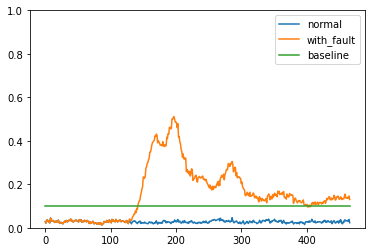

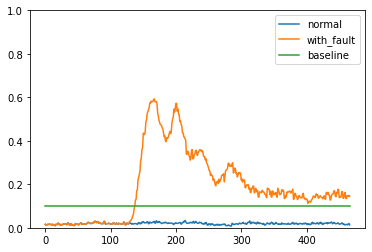

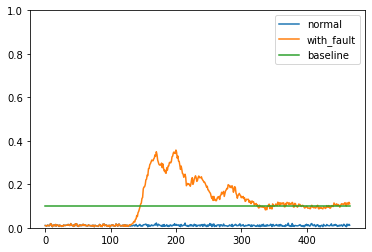

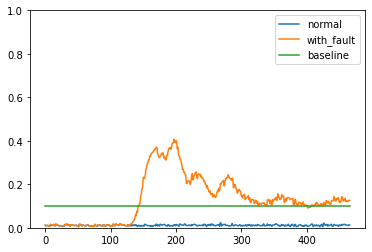

In [68]:
baseline = 0.1
run = 1
models = [model, model_2, model_3, model_4]


for i in range(len(models)):
  get_result(models[i], 0.1, run)

In [ ]:
#cross validation
for train_split, val_split in KFold().split([i+1 for i in range(500)]):
    train_df = fault_free_training[fault_free_training.simulationRun.isin(train_split)]
    val_df = fault_free_training[fault_free_training.simulationRun.isin(val_split)]


    scaler = preprocessing.MinMaxScaler()
    scaler.fit(train_df.iloc[:, 3:].values)

    train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
    val_df.iloc[:, 3:] = scaler.transform(val_df.iloc[:, 3:].values)

    train_ds = get_dataset(train_df, shuffle = True, repeat=True)
    val_ds = get_dataset(val_df)


    model = get_model() 


    model.fit(
        train_ds, 
        epochs = 20,
        steps_per_epoch = 1000,
        validation_data= val_ds,
        
    )

    break


Epoch 1/20
1000/1000 [==============================] - 17s 11ms/step - loss: 0.1071 - val_loss: 0.0980
Epoch 2/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0744 - val_loss: 0.0678
Epoch 3/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0604 - val_loss: 0.0538
Epoch 4/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0501 - val_loss: 0.0491
Epoch 5/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0485 - val_loss: 0.0479
Epoch 6/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0484 - val_loss: 0.0485
Epoch 7/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0451 - val_loss: 0.0421
Epoch 8/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0424 - val_loss: 0.0407
Epoch 9/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0420 - val_loss: 0.0427
Epoch 10/20
1000/1000 [==============================] - 10s 10m